## Executive Summary

This notebook explores the modeling of daily stock excess growth rates using Hidden Markov Models (HMMs). The analysis proceeds in two main stages:
1.  A standard HMM is built from historical in-sample data.
2.  This model is then tested against well-known "stylized facts" of financial returns, revealing its strengths (capturing return distributions) and weaknesses (failing to capture volatility clustering).

To address these weaknesses, a modified HMM that incorporates price jumps is introduced and analyzed in `HMM-WithJumps-Simulation-Notebook`

 # Build a Hidden Markov Model of Daily Stock Excess Growth Rate
We are constructing an Observable Markov Model (OMM) of the excess growth rate of a ticker `XYZ` where we define the excess growth as:
$$
\begin{equation*}
R_{ij} \equiv \left(\frac{1}{\Delta{t}}\right)\cdot\ln\left(\frac{S_{i,j}}{S_{i,j-1}}\right) - \bar{r}_{f}
\end{equation*}
$$
where $R_{ij}$ denotes the excess growth rate of equity $i$ at time $j$, $\Delta{t}$ denotes the time-step between $j-1\rightarrow{j}$ (units: years), $S_{i,\star}$ denotes the share price of equity $i$ at time $\star$, and $\bar{r}_{f}$ denotes the annualized risk free rate. In this work, we build a model of daily return.

## Model
Describe the day-to-day variation of the excess growth using a fully observable Markov model $\mathcal{M}$ represented by the tuple $\mathcal{M} = (\mathcal{S},\mathcal{O},\mathbf{P},\mathbf{E})$; $\mathcal{S}$ is the set of hidden states, $\mathcal{O}$ is the set of observable states, $\mathbf{T}$ is the transition matrix, i.e., $t_{ij}\in\mathbf{T}$ is the probability of moving from hidden state $i$ to hidden state $j$ in the next time step, and $\mathbf{E}$ is the emission matrix. Because we are fully observable, the emission matrix $\mathbf{E} = \mathbf{I}$, where $\mathbf{I}$ is the identity matrix.

## Objectives
- **Task 1:** Characterize the continuous distribution of returns using MLE and MCMC, then discretize this distribution to build a Hidden Markov Model (HMM).
- **Task 2:** Simulate the standard HMM and analyze its ability to reproduce key stylized facts of financial returns, particularly volatility clustering.
- **Task 3:** Save the final model artifacts for future use.

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our lab problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl).

In [1]:
include("Include.jl");

[ Info: Precompiling Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0] 

SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.
[ Info: Precompiling Optimization [7f7a1694-90dd-40f0-9382-eb1efda571ba] 

SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing Optimization [7f7a1694-90dd-40f0-9382-eb1efda571ba].
└   exception = Error when precom

## Setting Up Constants

In [2]:
risk_free_rate = 0.0421; # 17-Jun-2024 10-year treasury
Δt = (1/252); # time step 1 x trading in units of years
number_of_paths = 100; # number of potential futures should we look at
ticker = "AAPL"; # This is the ticker we want to explore

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2014` until `02-07-2025`, along with data for a few exchange-traded funds and volatility products during that time. In this block of code, we:
* Load and clean the historical data; store the cleaned data in the `dataset` variable. We then calculate the expected excess return $\mathbb{E}(R_{i})$ for each `ticker` in the `dataset.` Finally, you'll select a firm by changing the value in the `ticker` variable. We store the computed excess return for the `ticker` in the `Rᵢ` variable.

### Load the training data

The dataset for this analysis consists of daily open-high-low-close (OHLC) data for firms in the S&P 500, spanning from **January 3, 2014, to February 7, 2025**. This data was cleaned and split into training and testing sets in a separate preprocessing step.

We begin by loading the pre-cleaned **training dataset** below.

In [3]:
train_dataset = MyPortfolioDataSet() |> x->x["train_dataset"]

Dict{String, DataFrame} with 424 entries:
  "EMR"  => 2515×8 DataFrame…
  "CTAS" => 2515×8 DataFrame…
  "HSIC" => 2515×8 DataFrame…
  "KIM"  => 2515×8 DataFrame…
  "PLD"  => 2515×8 DataFrame…
  "IEX"  => 2515×8 DataFrame…
  "BAC"  => 2515×8 DataFrame…
  "CBOE" => 2515×8 DataFrame…
  "EXR"  => 2515×8 DataFrame…
  "NCLH" => 2515×8 DataFrame…
  "CVS"  => 2515×8 DataFrame…
  "DRI"  => 2515×8 DataFrame…
  "DTE"  => 2515×8 DataFrame…
  "ZION" => 2515×8 DataFrame…
  "AVY"  => 2515×8 DataFrame…
  "EW"   => 2515×8 DataFrame…
  "EA"   => 2515×8 DataFrame…
  "NWSA" => 2515×8 DataFrame…
  "CAG"  => 2515×8 DataFrame…
  "GILD" => 2515×8 DataFrame…
  "FCX"  => 2515×8 DataFrame…
  "GPC"  => 2515×8 DataFrame…
  "UNP"  => 2515×8 DataFrame…
  "CDW"  => 2515×8 DataFrame…
  "SBUX" => 2515×8 DataFrame…
  ⋮      => ⋮

In [4]:
train_dataset["AAPL"]

Row,volume,volume_weighted_average_price,open,close,high,low,timestamp,number_of_transactions
,Float64,Float64,Float64,Float64,Float64,Float64,DateTime,Int64
1,3.93215e8,19.4749,19.745,19.3207,19.775,19.3011,2014-01-03T05:00:00,148584
2,4.13437e8,19.3213,19.1946,19.4261,19.5286,19.0571,2014-01-06T05:00:00,131664
3,3.17731e8,19.3329,19.44,19.2871,19.4986,19.2116,2014-01-07T05:00:00,107327
4,2.58747e8,19.4038,19.2432,19.4093,19.4843,19.2389,2014-01-08T05:00:00,86874
5,2.79621e8,19.2943,19.5286,19.1614,19.5307,19.1196,2014-01-09T05:00:00,93562
6,3.05283e8,19.0659,19.2796,19.0336,19.3143,18.9682,2014-01-10T05:00:00,113063
7,3.79443e8,19.1801,18.9254,19.1332,19.375,18.9243,2014-01-13T05:00:00,130227
8,3.34937e8,19.4033,19.2221,19.5139,19.5261,19.2021,2014-01-14T05:00:00,114856
9,3.9389e8,19.9105,19.7686,19.9057,20.0071,19.7021,2014-01-15T05:00:00,136942


In [5]:
maximum_number_trading_days = nrow(train_dataset["AAPL"])

2515

In [6]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ train_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end

Lastly, let's get a sorted list of firms that we have in cleaned up `dataset` and save it in the `list_of_all_tickers::Array{String,1}` array

In [7]:
list_of_all_tickers = keys(dataset) |> collect |> x->sort(x)

424-element Vector{String}:
 "A"
 "AAL"
 "AAP"
 "AAPL"
 "ABBV"
 "ABT"
 "ACN"
 "ADBE"
 "ADI"
 "ADM"
 "ADP"
 "ADSK"
 "AEE"
 ⋮
 "WST"
 "WU"
 "WY"
 "WYNN"
 "XEL"
 "XOM"
 "XRAY"
 "XYL"
 "YUM"
 "ZBRA"
 "ZION"
 "ZTS"

We compute the expected (annualized) log growth rate by passing the `dataset` and the entire list of firms we have in the dataset (held in the $N\times{1}$ `list_of_all_tickers` array) to the [log_growth_matrix(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.log_growth_matrix).
* The result is stored in the `all_firms_return_matrix::Array{Float64,2}` variable, a $T-1\times{N}$ array of log return values. Each row of `all_firms_return_matrix` corresponds to a time value, while each column corresponds to a firm:

In [8]:
all_firms_excess_return_matrix = log_growth_matrix(dataset, list_of_all_tickers,
    Δt = Δt, risk_free_rate = risk_free_rate)

2514×424 Matrix{Float64}:
 -0.919654   6.23895   -2.91307    …  -0.797491   0.203794  -1.04737
  2.77416    1.02939    1.35029        2.09622   -0.84489    0.944368
  3.27095    0.813497  -0.036732       0.067777   1.1489    -2.62354
  0.604325  17.2178     1.65005        0.232616   3.1172    -0.410328
  1.77399    2.53751    3.27714        0.579577  -2.2108     4.36099
  0.57173   -4.00594   -0.83488    …  -0.904839  -1.95187   -3.15834
  2.81861   -0.525851   4.80363        1.7236    -1.81895   -1.1317
  2.00461    0.971404   1.86599        1.63387    4.40774   -0.179919
  1.27079    1.63203    0.0651592     -1.54918   -2.17906    1.39574
  1.17806    6.08747    0.890478      -1.57412    2.83574   -1.47836
 -0.479768   4.82799    0.96564    …  -0.363361   9.46617   -3.05083
  1.32071    3.57107   -2.38986        0.668513   4.48013    0.298431
 -4.78114    1.34375   -3.05834       -2.19455   -6.69117    1.36402
  ⋮                                ⋱                        
  6.83722   -

Extract the growth rate for your `ticker::String` of interest, and save this in the `Rᵢ::Array{Float64,1}` array. This is the observed _in-sample_ data.

In [9]:
Rᵢ = findfirst(x->x==ticker, list_of_all_tickers) |> i-> all_firms_excess_return_matrix[:,i]

2514-element Vector{Float64}:
 -2.0375223478275544
  0.10914876922831154
  0.8803750663536962
 -1.4682203338251638
 -3.0429957287125435
  1.4628147899343094
  2.8735076155145367
  6.460527170431677
 -1.2982327051214098
 -4.06684141859285
  0.2743555755863404
  3.0612658421029613
 -0.6804305505446159
  ⋮
  3.9894245670776525
  1.7161873979014124
 -0.9679855747953251
 -2.5218350546238932
  1.1174203156472817
 -0.537154399455329
 -1.8465998303560534
 -0.8731923124247634
 -1.25241258344301
 -0.8304923854497042
  1.7239736813280824
 -1.7974431493696004

## Task 1: Characterizing and Discretizing the Return Distribution
### Methodology: Building the Model from Data

To construct the HMM, we first need to define its components from the historical returns data (`Rᵢ`):

1.  **States:** The continuous range of daily returns is discretized into a finite number of states. Each state represents a specific market condition, from significant losses (State 1) to significant gains (State N). We define these states by calculating the quantiles of the historical return distribution.

2.  **Transition Matrix:** The probability of moving from one state to another on the next day is estimated by observing the frequency of these transitions in the historical data.

3.  **Emission Probabilities:** In this model, the emissions are deterministic. Being in a certain state means the return is within the predefined quantile range for that state.

First, consider the states $\mathcal{S}$. Suppose we number the excess return values, ranging from `super bad = 1,` $\dots$,` unchanged,` $\dots$,` super good = N,` where if $R\ll{0}$, then we are in the `super bad = 1,` state or $R\gg{0}$ we are in the `super good = N` state (or we are someplace in between).
* __Idea__: Use the [cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function) computed from the observed return series $R_{i,1}, \dots, R_{i,n}$ to partition the actual (historical) excess returns into one of a fixed number of categories. Once we have the categories, compute the probability that category $i$ on the day $k$ is followed by category $j$ on the day $k+1$. These values are entries in the state transition matrix $\hat{\mathbf{T}}$.
* To start, specify a value for the  `number_of_states` variable, where the `number_of_states` controls how many categories we are using when splitting up the excess return time series. We then set the `states` vector, which holds the states (numbered from `1`$\rightarrow$`number_of_states`).

In [46]:
number_of_states = 3; # specify a value here, too many states or too little states would impact the model performance. 100 should provide somewhat fair granuality 
states = range(1,stop=number_of_states) |> collect;

The `states` are hidden from the observer. Next, we set up the emissions matrix $\mathbf{E}$. For this example, because the states are __fully observable__, i.e., we can see the states directly,  the emission matrix $\mathbf{E}$ is the identity matrix $\mathbf{I}$:

In [47]:
E = diagm(ones(number_of_states))

3×3 Matrix{Float64}:
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0

### Estimate the transition matrix $\hat{\mathbf{T}}$ from market data
To estimate the transition matrix $\hat{\mathbf{T}}$, we'll estimate the transition probabilities from the excess return data calculated in the `Prerequisites` section and saved in the `Rᵢ` variable.

In [48]:
in_sample_dataset = Rᵢ[1:(maximum_number_trading_days-1)] # set of excess return

2514-element Vector{Float64}:
 -2.0375223478275544
  0.10914876922831154
  0.8803750663536962
 -1.4682203338251638
 -3.0429957287125435
  1.4628147899343094
  2.8735076155145367
  6.460527170431677
 -1.2982327051214098
 -4.06684141859285
  0.2743555755863404
  3.0612658421029613
 -0.6804305505446159
  ⋮
  3.9894245670776525
  1.7161873979014124
 -0.9679855747953251
 -2.5218350546238932
  1.1174203156472817
 -0.537154399455329
 -1.8465998303560534
 -0.8731923124247634
 -1.25241258344301
 -0.8304923854497042
  1.7239736813280824
 -1.7974431493696004

### 1a. Analyzing the Underlying Continuous Distribution

Before building our discrete-state HMM, we first seek to understand the underlying continuous probability distribution of the daily excess returns. A key part of modeling is choosing a distribution that accurately captures the stylized facts of the data, such as **"fat tails"** (a higher probability of extreme events than a normal distribution would suggest).

In this section, we will:
1.  Compare two candidate distributions: the **Laplace distribution** and the **Student's t-distribution**.
2.  Compare two different methodologies for fitting these distributions: **Maximum Likelihood Estimation (MLE)** and the more robust **Markov Chain Monte Carlo (MCMC)**.

First, we use our generic MCMC function to fit a **Student's t-distribution** to the return data. This is our primary candidate for a model that can capture fat tails. The output will be a `chain` object containing the full posterior distributions for the model's parameters: mean (`μ`), volatility (`σ`), and degrees-of-freedom (`ν`).

┌ Info: Found initial step size
└   ϵ = 0.025
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


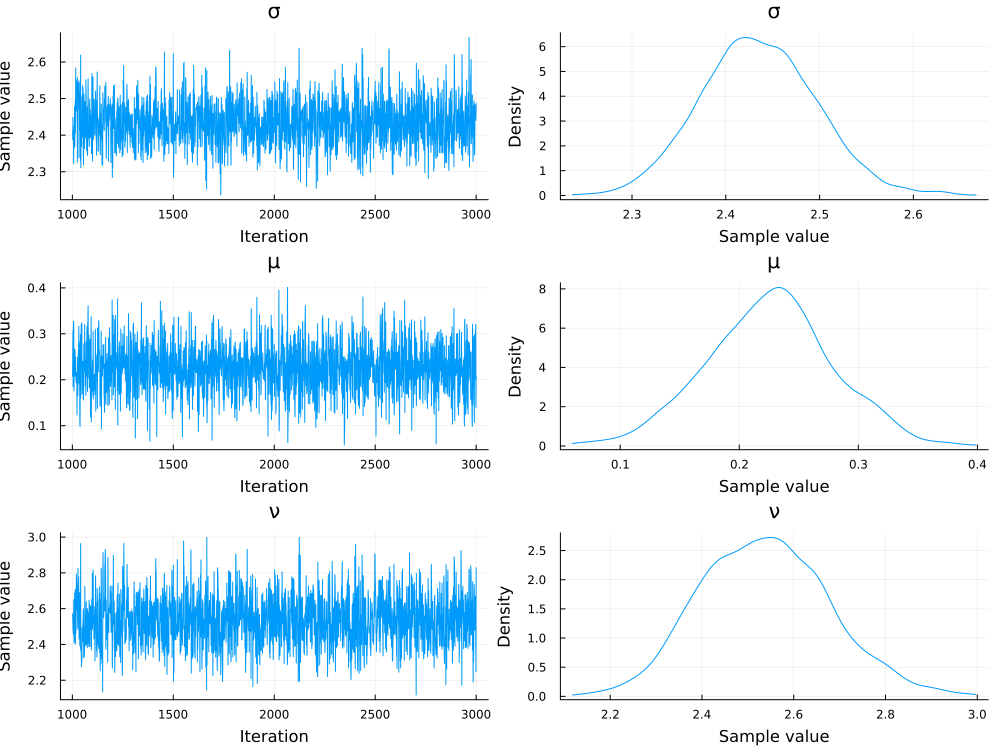

In [49]:
# To learn the Student's t-distribution:
chain_t = learn_distribution_mcmc(StudentTModel(), Rᵢ);

# You can now analyze chain_t and chain_laplace as before
plot(chain_t)


Next, for a direct comparison, we fit the **Laplace distribution** using the same MCMC methodology. This will produce a `chain` object containing posteriors for the Laplace parameters: mean (`μ`) and scale (`b`).

┌ Info: Found initial step size
└   ϵ = 0.025
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


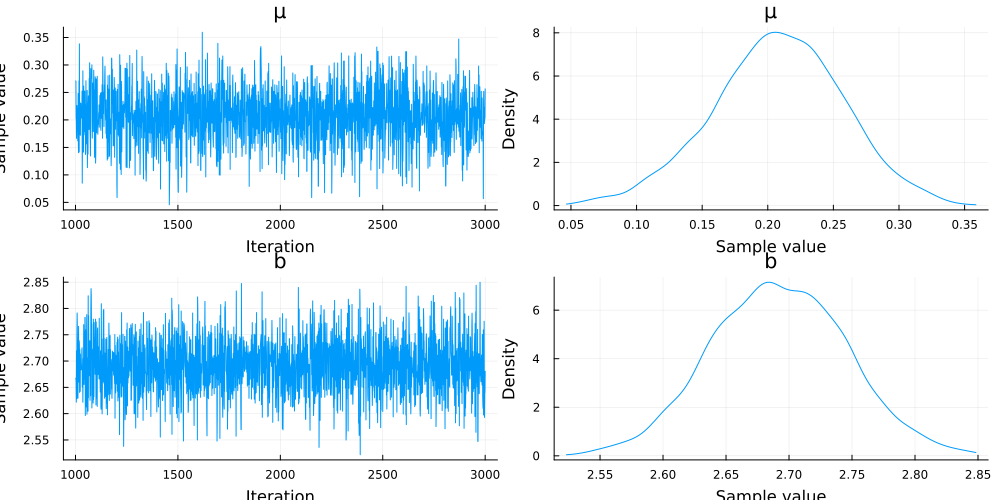

In [50]:
# To learn the Laplace distribution:
chain_laplace = learn_distribution_mcmc(LaplaceModel(), Rᵢ);

plot(chain_laplace)


Finally, we will prepare all of our fitted models for a head-to-head comparison. We will use the traditional **Maximum Likelihood Estimation (MLE)** to fit a Laplace distribution as a baseline. Then, we will bring together all the models—both MCMC and MLE—for a final comparison using visual plots and quantitative statistics.

In [51]:
# --- Prepare All Four Models ---

# 1. MLE Model
Laplace_MLE = fit_mle(Laplace, Rᵢ);

# 2. MCMC Models 
μ_t_mean = mean(chain_t[:μ])
σ_t_mean = mean(chain_t[:σ])
ν_t_mean = mean(chain_t[:ν])
StudentT_MCMC = LocationScale(μ_t_mean, σ_t_mean, TDist(ν_t_mean))

μ_laplace_mean = mean(chain_laplace[:μ])
b_laplace_mean = mean(chain_laplace[:b])
Laplace_MCMC = Laplace(μ_laplace_mean, b_laplace_mean);


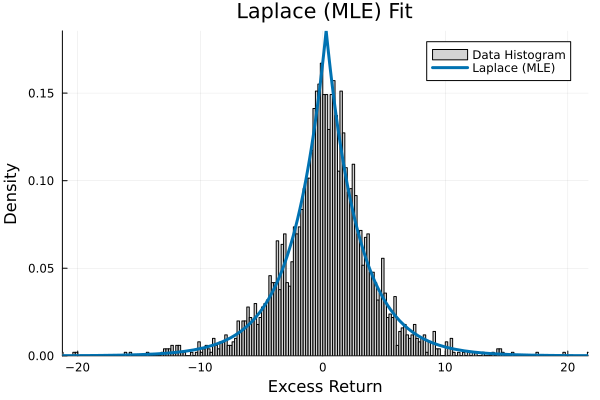

In [52]:
# --- Plot 1: Laplace (MLE) vs. Data ---

# Create a histogram of the actual returns data
histogram(Rᵢ, normalize=:pdf, bins=200, label="Data Histogram", c=:lightgray)

# Plot the Laplace (MLE) distribution
plot!(x -> pdf(Laplace_MLE, x), lw=3, label="Laplace (MLE)", c="#0072B2") # Blue

title!("Laplace (MLE) Fit")
xlabel!("Excess Return")
ylabel!("Density")
xlims!(extrema(Rᵢ))

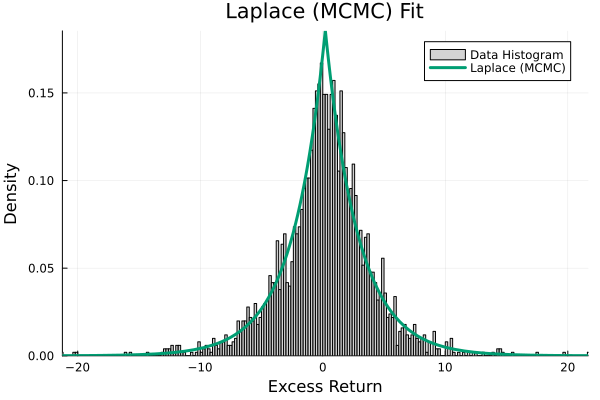

In [53]:
# --- Plot 3: Laplace (MCMC) vs. Data ---

# Create a histogram of the actual returns data
histogram(Rᵢ, normalize=:pdf, bins=200, label="Data Histogram", c=:lightgray)

# Plot the Laplace (MCMC) distribution
plot!(x -> pdf(Laplace_MCMC, x), lw=3, label="Laplace (MCMC)", c="#009E73") # Bluish Green

title!("Laplace (MCMC) Fit")
xlabel!("Excess Return")
ylabel!("Density")
xlims!(extrema(Rᵢ))

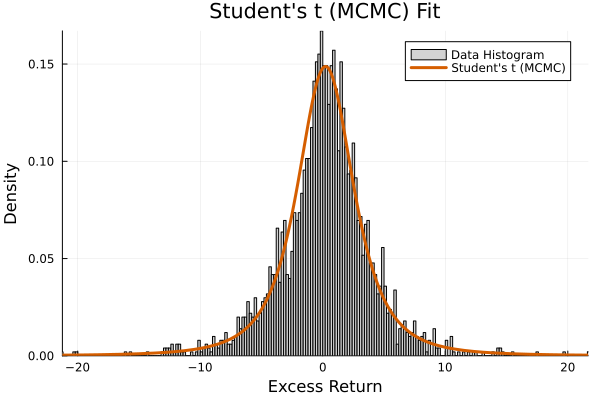

In [54]:
# --- Plot 2: Student's t (MCMC) vs. Data ---

# Create a histogram of the actual returns data
histogram(Rᵢ, normalize=:pdf, bins=200, label="Data Histogram", c=:lightgray)

# Plot the Student's t (MCMC) distribution
plot!(x -> pdf(StudentT_MCMC, x), lw=3, label="Student's t (MCMC)", c="#D55E00") # Vermillion/Orange

title!("Student's t (MCMC) Fit")
xlabel!("Excess Return")
ylabel!("Density")
xlims!(extrema(Rᵢ))

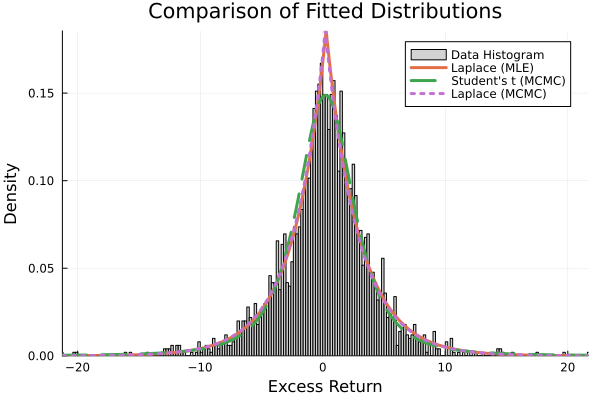

In [55]:
# ---  Visual Comparison of Four Distributions ---

# Create a histogram of the actual returns data
histogram(Rᵢ, normalize=:pdf, bins=200, label="Data Histogram", c=:lightgray)

# Plot the four models
plot!(x -> pdf(Laplace_MLE, x), lw=3, label="Laplace (MLE)")
plot!(x -> pdf(StudentT_MCMC, x), lw=3, label="Student's t (MCMC)", ls=:dash)
plot!(x -> pdf(Laplace_MCMC, x), lw=3, label="Laplace (MCMC)", ls=:dot)

title!("Comparison of Fitted Distributions")
xlabel!("Excess Return")
ylabel!("Density")
xlims!(extrema(Rᵢ))

In [56]:
# --- UPDATED: Quantitative Comparison of Four Distributions ---

# A. Summary Statistics
println("--- Summary Statistics ---")
println("Laplace (MLE):")
println("  Mean:      ", mean(Laplace_MLE))
println("  Variance:  ", var(Laplace_MLE))
println("  Kurtosis:  ", kurtosis(Laplace_MLE))

println("\nStudent's t (MCMC):")
println("  Mean:      ", mean(StudentT_MCMC))
println("  Variance:  ", var(StudentT_MCMC))
println("  Kurtosis:  ", kurtosis(StudentT_MCMC))

println("\nLaplace (MCMC):")
println("  Mean:      ", mean(Laplace_MCMC))
println("  Variance:  ", var(Laplace_MCMC))
println("  Kurtosis:  ", kurtosis(Laplace_MCMC))


# B. AIC Comparison (Lower is Better)
log_like_L_MLE = loglikelihood(Laplace_MLE, Rᵢ)
log_like_T_MCMC = loglikelihood(StudentT_MCMC, Rᵢ)
log_like_L_MCMC = loglikelihood(Laplace_MCMC, Rᵢ)

aic_L_MLE = 2*2 - 2*log_like_L_MLE
aic_T_MCMC = 2*3 - 2*log_like_T_MCMC
aic_L_MCMC = 2*2 - 2*log_like_L_MCMC

println("\n--- Model Comparison (Lower AIC is Better) ---")
println("AIC for Laplace (MLE):       ", aic_L_MLE)
println("AIC for Laplace (MCMC):      ", aic_L_MCMC)
println("AIC for Student's t (MCMC):  ", aic_T_MCMC)

--- Summary Statistics ---
Laplace (MLE):
  Mean:      0.275472995742301
  Variance:  14.499370724613431
  Kurtosis:  3.0

Student's t (MCMC):
  Mean:      0.2254440850896266
  Variance:  28.018054102645024
  Kurtosis:  Inf

Laplace (MCMC):
  Mean:      0.2074928820213717
  Variance:  14.49104727654335
  Kurtosis:  3.0

--- Model Comparison (Lower AIC is Better) ---
AIC for Laplace (MLE):       13497.272610885935
AIC for Laplace (MCMC):      13498.716473024158
AIC for Student's t (MCMC):  13533.877915860221


In [57]:
# Choose one of these to be your distribution in the variable d that will be used for generating CDF
d = Laplace_MLE;  # StudentT_MCMC or Laplace_MCMC or Laplace_MLE

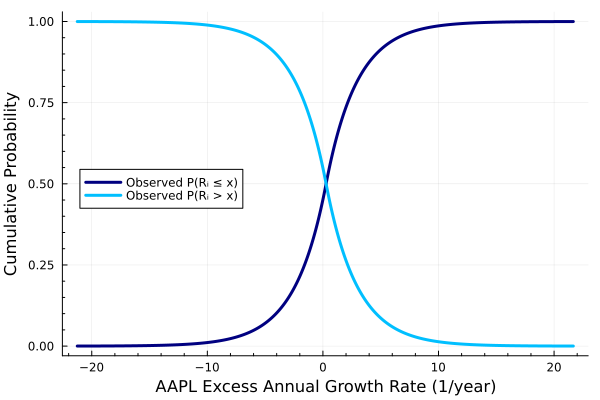

In [58]:
let

    # regions of return -
    number_of_samples = 1000;
    minimum_obs_growth = minimum(in_sample_dataset);
    maximum_obs_growth = maximum(in_sample_dataset);
    RA = range(minimum_obs_growth,stop = maximum_obs_growth, length = number_of_samples) |> collect;

    X = Array{Float64,2}(undef, number_of_samples,2);
    for i ∈ eachindex(RA)

        X[i,1] = RA[i];
        X[i,2] = cdf(d, RA[i]);
    end

    plot(X[:,1], X[:,2], lw=3, c=:navy, label="Observed P(Rᵢ ≤ x)", xminorticks=5, yminorticks=5)
    plot!(X[:,1], 1 .- X[:,2], lw=3, c=:deepskyblue1, label="Observed P(Rᵢ > x)", legend=:left)

    xlabel!("$(ticker) Excess Annual Growth Rate (1/year)", fontsize=18);
    ylabel!("Cumulative Probability", fontsize=18);
end

Next, we generate the percentile cutoffs that we use to establish the bounds that correspond to each category of return, i.e., `super bad` or `super good`, etc.

In [59]:
percentage_cutoff = range(0.0,stop=1.0,length=(number_of_states+1)) |> collect

4-element Vector{Float64}:
 0.0
 0.3333333333333333
 0.6666666666666666
 1.0

Now that we have the cutoffs, compute the lower and upper bound for each potentiual category. To do this, we'll use the [quantile function](https://juliastats.org/Distributions.jl/stable/univariate/#Statistics.quantile-Tuple{UnivariateDistribution,%20Real}) exported by the [Distributions.jl package](https://github.com/JuliaStats/Distributions.jl). For a given `0 ≤ q ≤ 1`, `quantile(d, q)` is the smallest value `x`
for which `cdf(d, x) ≥ q`.

In [60]:
bounds = Array{Float64,2}(undef, number_of_states, 3)
for s ∈ states
    bounds[s,1] = quantile(d,percentage_cutoff[s])
    bounds[s,2] = quantile(d,percentage_cutoff[s+1])
    bounds[s,3] = s
end
bounds

3×3 Matrix{Float64}:
 -Inf        -0.816252  1.0
  -0.816252   1.3672    2.0
   1.3672    Inf        3.0

Now that we have the category bounds, let's take the excess return data and determine which state an excess return observation corresponds to. For each sample in the `in_sample_dataset`:
* Classify the sample value into one of the possible categories. Let `state = 1` equal the worst return, and `state = number_of_states` equal the best return. Save these results in the `encoded_in_sample` array:

In [61]:
encoded_in_sample = Array{Int64,1}();
for i ∈ eachindex(in_sample_dataset)
    value = in_sample_dataset[i];

    class_index = 1;
    for s ∈ states
        if (bounds[s,1] ≤ value && value < bounds[s,2])
            class_index = s;
            break;
        end
    end
    push!(encoded_in_sample, class_index);
end
encoded_in_sample

2514-element Vector{Int64}:
 1
 2
 2
 1
 1
 3
 3
 3
 1
 1
 2
 3
 2
 ⋮
 3
 3
 1
 1
 2
 2
 1
 1
 1
 1
 3
 1

This cell can be used to check the most frequent hidden state.

In [62]:
counts = countmap(encoded_in_sample) |> argmax;

In the matrix $\mathbf{T}$ compute the `counts` for transition from state `i` to state `j`:

In [63]:
T = zeros(number_of_states, number_of_states)
number_insample = length(encoded_in_sample);
for i ∈ 2:number_insample
    start_index = encoded_in_sample[i-1];
    stop_index = encoded_in_sample[i];
    T[start_index,stop_index] += 1;
end
T

3×3 Matrix{Float64}:
 354.0  216.0  268.0
 264.0  271.0  259.0
 220.0  307.0  354.0

From the `counts` matrix $\mathbf{T}$, compute the transtion probability matrix $\hat{\mathbf{T}}$:

In [64]:
T̂ = zeros(number_of_states, number_of_states)
for row ∈ states
    Z = sum(T[row,:]);
    for col ∈ states
        T̂[row,col] = (1/Z)*T[row,col]
    end
end
T̂

3×3 Matrix{Float64}:
 0.422434  0.257757  0.319809
 0.332494  0.34131   0.326196
 0.249716  0.348468  0.401816

### Generate the stationary distribution from the estimated $\hat{\mathbf{T}}$ matrix
Generate the stationary distribution for the estimated transition matrix $\hat{\mathbf{T}}$ and use it to construct a [Categorical distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Categorical) representing the stationary distrubution, save the [Categorical distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Categorical) in the `π̄`-variable:

In [65]:
power_value = 50;
π̄ = (T̂^power_value) |> tmp -> Categorical(tmp[1,:]); # compute the stationary distribution (approx value is ok)

## Task 2: In-Sample Analysis of the Standard HMM
To do the simulation, we first build a [`MyHiddenMarkovModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/markov/#VLQuantitativeFinancePackage.MyHiddenMarkovModel), which holds the data for our Markov model. We use a [`build(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/markov/#VLQuantitativeFinancePackage.build-Tuple{Type{MyHiddenMarkovModel},%20NamedTuple}), which takes information about the `states,` the estimated transition matrix $\hat{\mathbf{T}}$, and the emission matrix $\mathbf{E}$ and returns a [`MyHiddenMarkovModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/markov/#VLQuantitativeFinancePackage.MyHiddenMarkovModel), which we save in the `model` variable.

In [66]:
model = build(MyHiddenMarkovModel, (
    states = states,
    T = T̂,
    E = E
));

### Implement the `MARKOV-SIMULATION` to generate hypothetical return sequences
Generate 'number_of_paths' example sequences, each containing 'number_of_steps' days. These variables determine the length and number of our hypothetical return sequences. Assume each path starts from a draw from the stationary distribution `π̄.`
* Save the simulated return sequences in the `archive::Array{Int64,2}(undef, number_of_steps, number_of_paths)` array, where the `row` index corresponds to a path, and the `col` index corresponds to a day.
* We have implemented some shortcut logic to speed up the implementation. To evaluate the Markov model for a `number_of_steps,` issue the command `model(start_state, number_of_steps).` This will compute a chain with `number_of_steps` starting as `start_state` and return the simulated sequence as an `array.`

In [67]:
number_of_steps = maximum_number_trading_days-1;
encoded_archive = Array{Int64,2}(undef, number_of_steps, number_of_paths);
for i ∈ 1:number_of_paths
    start_state = rand(π̄);
    tmp = model(start_state, number_of_steps)
    for j ∈ 1:number_of_steps
        encoded_archive[j,i] = tmp[j]
    end
end
encoded_archive

2514×100 Matrix{Int64}:
 2  1  2  3  2  1  1  3  1  3  2  3  1  …  3  3  2  1  3  2  2  1  3  3  1  3
 3  3  1  2  1  3  1  3  2  3  2  2  3     1  2  3  1  3  1  1  1  2  1  3  3
 3  3  1  3  1  3  3  2  2  2  1  1  1     1  2  1  2  3  1  3  2  2  1  2  1
 3  3  2  1  3  1  3  2  2  2  1  2  3     1  2  3  2  1  2  2  3  1  3  1  3
 1  2  1  1  2  1  3  2  3  3  3  2  3     3  3  3  2  2  1  2  2  3  1  2  3
 3  1  2  1  2  1  1  3  1  3  3  3  1  …  3  1  1  2  2  2  1  3  3  1  1  1
 3  3  3  1  1  1  3  1  2  2  3  1  2     3  2  2  2  2  2  3  1  2  2  1  1
 3  1  2  3  3  2  3  1  3  3  3  1  2     3  2  2  2  1  2  3  2  2  3  2  1
 3  1  3  3  3  2  1  2  1  3  3  3  2     3  3  2  3  1  2  2  1  3  3  1  3
 3  1  1  3  2  3  3  1  1  3  2  2  2     3  3  1  2  2  2  3  2  2  1  3  2
 3  3  3  3  2  1  1  1  1  2  3  1  1  …  2  2  1  2  1  2  1  2  3  3  3  3
 2  2  2  1  3  3  3  1  1  1  2  1  1     1  3  3  1  3  2  1  1  3  2  2  1
 3  1  3  2  2  3  3  1  1  3  2  3  2  

In [68]:
actual_sample_bounds = copy(bounds);
actual_sample_bounds[1,1] = minimum(in_sample_dataset);
actual_sample_bounds[end,2] = maximum(in_sample_dataset)
actual_sample_bounds

3×3 Matrix{Float64}:
 -21.2536    -0.816252  1.0
  -0.816252   1.3672    2.0
   1.3672    21.664     3.0

### Decode operation
To turn the state $s\in\mathcal{S}$ back into an excess return value, we need to __decode__ the state. To do this, let's construct a [Normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) describing the observed return values associated with each state in the `encoded_in_sample` dataset.
* We collect the observed excess return samples associated with a particular state $s$, store them in a `tmp` array, and use [Maximum Likelihood Estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) to estimate a [Normal distribution exported from the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal)

In [69]:
decode_distribution_model = Dict{Int,Normal}()
for s ∈ states

    # what indexes correspond to state s
    index_collection_state_s = findall(x-> x == s, encoded_in_sample);
    tmp = Array{Float64,1}();
    for i ∈ index_collection_state_s
        decoded_value = Rᵢ[i];
        push!(tmp, decoded_value);
    end
    decode_distribution_model[s] = fit_mle(Normal,tmp);
end
decode_distribution_model;

Then, generate a random value for the excess return by sampling the appropriate [Normal distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal). We develop `number_of_paths` trajectories, each containing `number_of_steps` values. We store these values in the `decoded_archive` variable:

In [70]:
in_sample_decoded_archive = Array{Float64,2}(undef, number_of_steps, number_of_paths);
for i ∈ 1:number_of_paths
    for j ∈ 1:number_of_steps
        s = encoded_archive[j,i];
        in_sample_decoded_archive[j,i] =  decode_distribution_model[s] |> d -> rand(d)
    end
end
in_sample_decoded_archive # actual excess growth value

2514×100 Matrix{Float64}:
  1.04701    -3.49388     0.390831   …   0.388074  -3.8685     3.13001
  2.97087     3.85702     0.602482      -0.935812   8.56012    5.021
 -0.171927    0.156791   -4.41725       -0.45565    0.847735  -5.29705
  1.15256     1.87775    -0.0754408      2.31559   -5.4522     3.30922
 -2.21889     0.618592   -3.0301        -0.965923  -0.530045   4.9585
  5.17943     1.92905     0.0445992  …  -4.98997   -2.68194   -2.72287
  4.31313     2.6233      3.22363       -0.48043   -6.25746   -4.38736
  2.84057    -3.89562     0.0729538      3.89843    1.58518   -2.50667
  5.96982    -4.5749      6.36187        6.47338   -1.0846     4.69818
  7.05988    -2.6969     -8.47919       -2.59189    0.742673   0.168327
  1.16584     3.9521      3.61631    …   4.33106    6.37567    6.59989
  0.167387    0.260113   -0.0328636     -0.239495   1.37549   -6.32483
  2.73169    -2.19279     9.10982       -0.751302   0.163784  -2.27011
  ⋮                                  ⋱               

### Visualize an example in-sample return trajectory
`Unhide` the code block to see how we plotted the observed (red) and simulated (blue) excess growth rate values for a randomly selected sample model generated sample path.

`Unhide` the code block below to see how we plotted the observed and simulated excess annual growth rate distribution for the in-sample data.

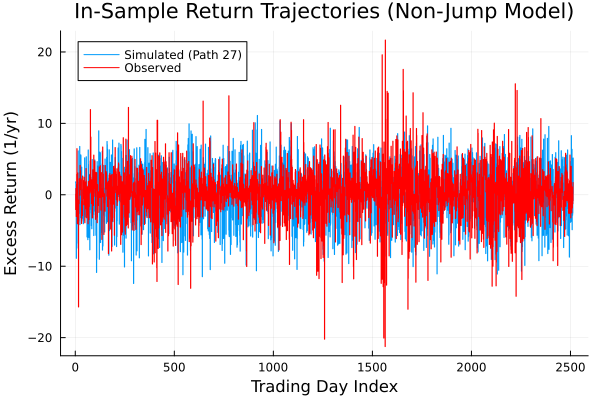

In [71]:
let
    # Select a random path to plot, just like in your working example
    index_to_plot = rand(1:number_of_paths)

    # Plot the SIMULATED data first, creating the plot
    plot(in_sample_decoded_archive[:, index_to_plot], linetype=:steppost, label="Simulated (Path $(index_to_plot))")

    # Add the OBSERVED data to the plot, slicing it to match the simulation length
    plot!(in_sample_dataset[1:(number_of_steps - 1)], linetype=:steppost, c=:red, label="Observed")
    
    # Add labels and a title
    xlabel!("Trading Day Index")
    ylabel!("Excess Return (1/yr)")
    title!("In-Sample Return Trajectories (Non-Jump Model)")
end

### Check: Are the Simulated and observed in-sample distributions the same?
If our Markov model is correct, then the observed excess growth rate distribution and the excess growth distribution calculated by our model should look like they are drawn from the same distribution. To check this hypothesis, use [the ApproximateTwoSampleKSTest exported by the HypothesisTests.jl package](https://github.com/JuliaStats/HypothesisTests.jl) with the hypotheses:
* `H0:null hypothesis` is that `x` and `y` are drawn from the same distribution against the `H1:alternative hypothesis` that `x` and `y` come from different distributions.

Let's run [the ApproximateTwoSampleKSTest function](https://github.com/JuliaStats/HypothesisTests.jl) on a single (randomly selected) example trajectory to see what happens (most of the time, we fail to reject `H0`, i.e., the test suggests `x` and `y` are from the same distribution):

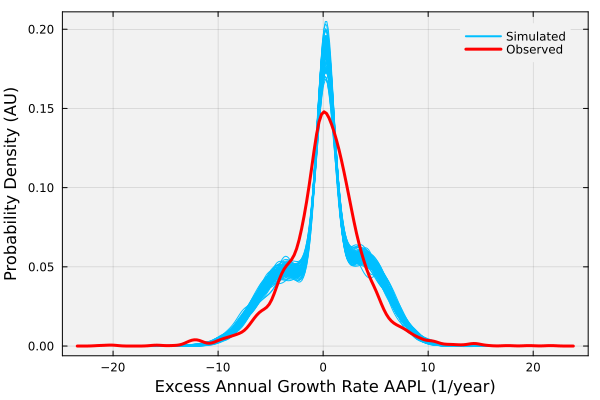

In [72]:
let
    q = plot();
    density!(in_sample_decoded_archive[:,1], lw=2, c=:deepskyblue1, label="Simulated",
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    for i ∈ 2:number_of_paths
        density!(in_sample_decoded_archive[:,i], lw=1, c=:deepskyblue1, label="")
    end
    density!(in_sample_dataset, c=:red, lw=3, label="Observed")
    xlabel!("Excess Annual Growth Rate $(ticker) (1/year)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
    current()
end

In [73]:
ApproximateTwoSampleKSTest(in_sample_dataset,in_sample_decoded_archive[:,rand(1:number_of_paths)])

Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.0588703

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.0003

Details:
    number of observations:   [2514,2514]
    KS-statistic:              2.0872000711081222


However, we have `number_of_paths` example trajectories (not just one), so let's do the same test on each sample and compute an overall expected score. Specify a `pvalue_cutoff` value to check against. If the test returns `pvalue > pvalue_cutoff,` then we fail to reject `H0:null hypothesis`, i.e., `x` and `y` appear to be drawn from the same distribution.

In [74]:
let
    pvalue_cutoff = 0.05; # cutoff
    pass_counter = 0;
    for i ∈ 1:number_of_paths
        test_value = ApproximateTwoSampleKSTest(in_sample_dataset,in_sample_decoded_archive[:,i]) |> pvalue
        if (test_value > pvalue_cutoff)
            pass_counter += 1 # we pass (fail to reject) x and y are from the same distribution
        end
    end
    println("Pass percentage: $((pass_counter/number_of_paths)*100)%")
end

Pass percentage: 0.0%


#### Anderson-Darling Test
The Anderson-Darling test is another method for testing whether two samples of data come from the same distribution. A key advantage of the A-D test over the K-S test is its higher sensitivity to differences in the tails of the distributions. This is particularly relevant for financial time series, where capturing tail risk and extreme events is critical.

In [75]:
KSampleADTest(in_sample_dataset,in_sample_decoded_archive[:,rand(1:number_of_paths)])

k-sample Anderson-Darling test
------------------------------
Population details:
    parameter of interest:   not implemented yet
    value under h_0:         NaN
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: reject h_0
    one-sided p-value:           <1e-04

Details:
    number of samples:        2
    number of observations:   5028
    SD of A²k:                0.7611095325190996
    A²k statistic:            9.65873061275365
    standardized statistic:   11.376457977204963
    modified test:            true
    p-value calculation:      asymptotic


In [76]:
let
    pvalue_cutoff = 0.05; # cutoff
    pass_counter = 0;
    for i ∈ 1:number_of_paths
        test_value = KSampleADTest(in_sample_dataset,in_sample_decoded_archive[:,i]) |> pvalue
        if (test_value > pvalue_cutoff)
            pass_counter += 1 # we pass (fail to reject) x and y are from the same distribution
        end
    end
    println("Pass percentage: $((pass_counter/number_of_paths)*100)%")
end

Pass percentage: 0.0%


#### Jensen-Shannon Divergence
The Jensen-Shannon (J-S) divergence is a method of measuring the similarity between two probability distributions, bounded between 0 (identical distributions) and 1 (maximally different distributions). Unlike the K-S and A-D tests, it is not a hypothesis test but rather a symmetric and smoothed metric of divergence, often used in information theory and for evaluating generative models.

In [94]:
let
    # --- FIX: Define a single, consistent set of bins based on the historical data ---
    # This ensures all simulations are compared against the same standard.
    min_edge = minimum(in_sample_dataset);
    max_edge = maximum(in_sample_dataset);
    bins = range(min_edge, stop=max_edge, length=100); # Use 100 bins based on historical range

    # Create the normalized histogram for the historical data ONCE
    p = normalize(fit(Histogram, in_sample_dataset, bins), mode=:pdf);

    # --- Calculate the average J-S divergence across all simulated paths ---
    total_jsd = 0.0;
    number_of_paths = size(in_sample_decoded_archive, 2);

    for i in 1:number_of_paths
        # Select the current simulated path
        simulated_path = in_sample_decoded_archive[:, i];
        
        # Create the normalized histogram for the simulation using the FIXED bins
        q = normalize(fit(Histogram, simulated_path, bins), mode=:pdf);

        # Calculate the J-S Divergence using the histogram weights and add to total
        total_jsd += js_divergence(p.weights, q.weights);
    end

    # Compute the average JSD
    average_jsd = total_jsd / number_of_paths;

    println("Average Jensen-Shannon Divergence:")
    println("---------------------------------")
    println("Average JSD: ", average_jsd)
    println("(Value closer to 0 indicates higher similarity between the distributions)")
end

Average Jensen-Shannon Divergence:
---------------------------------
Average JSD: 0.06800906413015621
(Value closer to 0 indicates higher similarity between the distributions)


In [91]:
let
    # --- Configuration for the JSD Pass/Fail Test ---
    jsd_threshold = 0.05; # Define a cutoff for a "good" JSD score. Lower is better.
    pass_counter = 0;
    number_of_paths = size(in_sample_decoded_archive, 2);

    # --- Define a single, consistent set of bins based on the historical data ---
    min_edge = minimum(in_sample_dataset);
    max_edge = maximum(in_sample_dataset);
    bins = range(min_edge, stop=max_edge, length=100);

    # Create the normalized histogram for the historical data ONCE
    p = normalize(fit(Histogram, in_sample_dataset, bins), mode=:pdf);

    # --- Loop through each path and test it individually ---
    for i in 1:number_of_paths
        # Select the current simulated path
        simulated_path = in_sample_decoded_archive[:, i];
        
        # Create the normalized histogram for the simulation using the FIXED bins
        q = normalize(fit(Histogram, simulated_path, bins), mode=:pdf);

        # Calculate the J-S Divergence for this path
        jsd_value = js_divergence(p.weights, q.weights);
        
        # Check if the JSD score is below the threshold
        if (jsd_value < jsd_threshold)
            pass_counter += 1; # This path "passes" the test
        end
    end

    # --- Report the final pass percentage ---
    pass_percentage = (pass_counter / number_of_paths) * 100;
    
    println("Jensen-Shannon Divergence Test:")
    println("-------------------------------")
    println("JSD Threshold: < $(jsd_threshold)")
    println("Pass Percentage: $(round(pass_percentage, digits=2))%")
end

Jensen-Shannon Divergence Test:
-------------------------------
JSD Threshold: < 0.05
Pass Percentage: 0.0%


In [87]:
in_sample_decoded_archive

2514×100 Matrix{Float64}:
  1.04701    -3.49388     0.390831   …   0.388074  -3.8685     3.13001
  2.97087     3.85702     0.602482      -0.935812   8.56012    5.021
 -0.171927    0.156791   -4.41725       -0.45565    0.847735  -5.29705
  1.15256     1.87775    -0.0754408      2.31559   -5.4522     3.30922
 -2.21889     0.618592   -3.0301        -0.965923  -0.530045   4.9585
  5.17943     1.92905     0.0445992  …  -4.98997   -2.68194   -2.72287
  4.31313     2.6233      3.22363       -0.48043   -6.25746   -4.38736
  2.84057    -3.89562     0.0729538      3.89843    1.58518   -2.50667
  5.96982    -4.5749      6.36187        6.47338   -1.0846     4.69818
  7.05988    -2.6969     -8.47919       -2.59189    0.742673   0.168327
  1.16584     3.9521      3.61631    …   4.33106    6.37567    6.59989
  0.167387    0.260113   -0.0328636     -0.239495   1.37549   -6.32483
  2.73169    -2.19279     9.10982       -0.751302   0.163784  -2.27011
  ⋮                                  ⋱               

#### Kullback-Leibler (KL) Divergence
The Kullback-Leibler (KL) divergence, originating from information theory, measures how one probability distribution `P` diverges from a second, expected probability distribution `Q`. It quantifies the "information loss" when `Q` is used to approximate `P`. Unlike J-S divergence, KL divergence is **asymmetric**, meaning `KL(P||Q)` is not equal to `KL(Q||P)`. It can also be unstable, becoming infinite if `Q` assigns zero probability to an event that `P` does not, a common issue when comparing distributions from sampled data.

In [78]:
let
    # We will calculate the average KL divergence across all simulated paths
    total_kl = 0.0;
    number_of_paths = size(in_sample_decoded_archive, 2);
    finite_paths_count = 0; # To count paths with finite KL divergence
    
    for i in 1:number_of_paths
        
        # Select the current simulated path
        simulated_path = in_sample_decoded_archive[:, i];
        
        # Create histograms with a common set of bins
        min_edge = min(minimum(in_sample_dataset), minimum(simulated_path));
        max_edge = max(maximum(in_sample_dataset), maximum(simulated_path));
        bins = range(min_edge, stop=max_edge, length=100);
    
        # Create normalized histograms (PDFs)
        p = normalize(fit(Histogram, in_sample_dataset, bins), mode=:pdf);
        q = normalize(fit(Histogram, simulated_path, bins), mode=:pdf);
    
        # Add a small epsilon to q to avoid zeros in log calculation, which would result in infinity
        epsilon = 1e-10;
        q.weights .+= epsilon;
        q.weights ./= sum(q.weights); # Re-normalize
    
        # Calculate the KL Divergence and add to total if it's finite
        kl_div = kl_divergence(p.weights, q.weights);
        if isfinite(kl_div)
            total_kl += kl_div;
            finite_paths_count += 1;
        end
    end
    
    # Compute the average KL divergence over paths that yielded a finite result
    average_kl = total_kl / finite_paths_count;
    
    println("Average Kullback-Leibler Divergence:")
    println("-----------------------------------")
    println("Average KL: ", average_kl)
    println("Calculated over ", finite_paths_count, " of ", number_of_paths, " paths with finite results.")
    println("(Value closer to 0 indicates higher similarity)")
end

Average Kullback-Leibler Divergence:
-----------------------------------
Average KL: 2.6802503113459593
Calculated over 100 of 100 paths with finite results.
(Value closer to 0 indicates higher similarity)


### Task 4: Hyperparameter Optimization via Grid Search
To enhance the model's performance, we need to find the optimal value for its most critical hyperparameter: the **number of hidden states**. Too few states may fail to capture the complexity of market dynamics, while too many can lead to overfitting and unstable simulations.

This grid search automates the process by systematically testing a predefined list of values for the number of states. For each value, it performs the following steps:
1.  Builds a new HMM with that number of states.
2.  Runs a full simulation.
3.  Evaluates the simulation's quality using a **composite loss function**.

This loss function is designed to produce a holistically realistic model by combining two key metrics:
- **J-S Divergence**: Measures how well the simulated return distribution matches the historical distribution.
- **ACF MSE**: Measures how well the model replicates **volatility clustering** by comparing the autocorrelation of absolute returns.

The goal is to identify the number of states that minimizes this combined loss, thereby yielding the most robust and accurate model across multiple stylized facts.

In [79]:


println("Starting self-contained hyperparameter grid search...")

# --- Helper Functions (Replicating the logic of your custom types) ---

"""
Discretizes a continuous return series into states based on quantile bins.
"""
function discretize_returns(returns, quantiles)
    num_states = length(quantiles) - 1
    states = zeros(Int, length(returns))
    for (i, r) in enumerate(returns)
        # Find which bin the return falls into
        for j in 1:num_states
            if r >= quantiles[j] && r <= quantiles[j+1]
                states[i] = j
                break
            end
        end
        # Handle edge case for the last bin
        if states[i] == 0
            states[i] = num_states
        end
    end
    return states
end

"""
Estimates the state transition matrix from a sequence of discrete states.
"""
function estimate_transition_matrix(states, num_states)
    T = zeros(num_states, num_states)
    for i in 1:(length(states) - 1)
        current_state = states[i]
        next_state = states[i+1]
        T[current_state, next_state] += 1
    end
    # Normalize rows to sum to 1
    for i in 1:num_states
        row_sum = sum(T[i, :])
        if row_sum > 0
            T[i, :] ./= row_sum
        else
            # If a state is never visited, assume uniform transition
            T[i, :] .= 1.0 / num_states
        end
    end
    return T
end

"""
Simulates paths from an HMM with an added Poisson jump process.
"""
function simulate_hmm_with_jumps(T, pi_vector, quantiles, num_steps, num_paths, jump_params)
    num_states = size(T, 1)
    simulated_returns = zeros(num_steps, num_paths)
    
    jump_dist = Normal(jump_params.μ_jump, jump_params.σ_jump)
    poisson_dist = Poisson(jump_params.λ * jump_params.Δt)

    for p in 1:num_paths
        # Initialize the first state
        current_state = wsample(1:num_states, pi_vector)
        
        for t in 1:num_steps
            # 1. Get base return from HMM state (sample uniformly from the quantile bin)
            lower_bound = quantiles[current_state]
            upper_bound = quantiles[current_state+1]
            base_return = rand() * (upper_bound - lower_bound) + lower_bound
            
            # 2. Add Poisson jump
            jump_return = sum(rand(jump_dist, rand(poisson_dist)))
            
            # 3. Store total return
            simulated_returns[t, p] = base_return + jump_return
            
            # 4. Transition to the next state
            current_state = wsample(1:num_states, T[current_state, :])
        end
    end
    return simulated_returns
end


# --- Grid Search Configuration ---
hidden_states_grid = [20, 50, 80, 120, 180, 250];
loss_weights = (jsd=0.5, acf_mse=0.5);
acf_lags = 20;

# --- Pre-calculate Historical Data ---
finite_historical_returns = filter(isfinite, in_sample_dataset);
historical_acf = autocor(abs.(finite_historical_returns), 1:acf_lags);

# --- Store Results ---
results = DataFrame(NumberOfStates=Int[], JSD_Loss=Float64[], ACF_MSE_Loss=Float64[], CompositeLoss=Float64[]);

# --- Main Grid Search Loop ---
for num_states in hidden_states_grid
    
    println("\\n--- Testing $(num_states) hidden states ---");
    
    # 1. BUILD THE HMM MODEL
    quantiles = quantile(d, range(0, 1, length=num_states+1));
    discrete_historical_states = discretize_returns(in_sample_dataset, quantiles);
    T_matrix = estimate_transition_matrix(discrete_historical_states, num_states);
    pi_vector = normalize(fit(Histogram, discrete_historical_states[1:100], 1:num_states).weights, 1); # Initial dist from first 100 days

    # 2. RUN SIMULATION
    jump_params = (λ=10.0, μ_jump=0.0, σ_jump=5.0, Δt=Δt);
    all_simulated_returns = simulate_hmm_with_jumps(T_matrix, pi_vector, quantiles, length(in_sample_dataset), number_of_paths, jump_params);

    # 3. CALCULATE LOSSES
    # A. Jensen-Shannon Divergence
    total_jsd = 0.0;
    valid_paths = 0;
    for i in 1:number_of_paths
        finite_simulated = filter(isfinite, all_simulated_returns[:, i]);
        if isempty(finite_simulated) continue end

        min_edge = min(minimum(finite_historical_returns), minimum(finite_simulated));
        max_edge = max(maximum(finite_historical_returns), maximum(finite_simulated));
        if !isfinite(min_edge) || !isfinite(max_edge) continue end

        bins = range(min_edge, stop=max_edge, length=100);
        p_hist = normalize(fit(Histogram, finite_historical_returns, bins), mode=:pdf).weights;
        q_hist = normalize(fit(Histogram, finite_simulated, bins), mode=:pdf).weights;
        
        jsd_val = js_divergence(p_hist, q_hist);
        if isfinite(jsd_val)
            total_jsd += jsd_val;
            valid_paths += 1;
        end
    end
    avg_jsd = (valid_paths > 0) ? total_jsd / valid_paths : Inf;

    # B. ACF Mean Squared Error
    simulated_acfs = [autocor(abs.(filter(isfinite, all_simulated_returns[:,i])), 1:acf_lags) for i in 1:number_of_paths if any(isfinite, all_simulated_returns[:,i])];
    avg_sim_acf = !isempty(simulated_acfs) ? mean(simulated_acfs) : fill(Inf, acf_lags);
    acf_mse = isfinite(avg_sim_acf[1]) ? mean((historical_acf .- avg_sim_acf).^2) : Inf;
    
    # C. Composite Loss
    composite_loss = (isfinite(avg_jsd) && isfinite(acf_mse)) ? (loss_weights.jsd * avg_jsd) + (loss_weights.acf_mse * acf_mse) : Inf;
    
    # 4. STORE RESULTS
    push!(results, (num_states, avg_jsd, acf_mse, composite_loss));
    println("JSD Loss: $(round(avg_jsd, digits=4)), ACF MSE Loss: $(round(acf_mse, digits=4)), Composite Loss: $(round(composite_loss, digits=4))");
end

# --- Final Report ---
println("\n\n--- Grid Search Results ---")
sort!(results, :CompositeLoss);
pretty_table(results)

best_params = first(results);
println("\nOptimal Number of Hidden States: $(best_params.NumberOfStates) with a loss of $(round(best_params.CompositeLoss, digits=5))")

Starting self-contained hyperparameter grid search...
\n--- Testing 20 hidden states ---
JSD Loss: 0.0637, ACF MSE Loss: 0.0153, Composite Loss: 0.0395
\n--- Testing 50 hidden states ---
JSD Loss: 0.0268, ACF MSE Loss: 0.0147, Composite Loss: 0.0208
\n--- Testing 80 hidden states ---
JSD Loss: 0.0217, ACF MSE Loss: 0.0142, Composite Loss: 0.018
\n--- Testing 120 hidden states ---
JSD Loss: 0.019, ACF MSE Loss: 0.0138, Composite Loss: 0.0164
\n--- Testing 180 hidden states ---
JSD Loss: 0.0186, ACF MSE Loss: 0.014, Composite Loss: 0.0163
\n--- Testing 250 hidden states ---
JSD Loss: 0.0163, ACF MSE Loss: 0.0136, Composite Loss: 0.0149


--- Grid Search Results ---
┌────────────────┬───────────┬──────────────┬───────────────┐
│ NumberOfStates │  JSD_Loss │ ACF_MSE_Loss │ CompositeLoss │
│          Int64 │   Float64 │      Float64 │       Float64 │
├────────────────┼───────────┼──────────────┼───────────────┤
│            250 │ 0.0162665 │    0.0136241 │     0.0149453 │
│            180 │

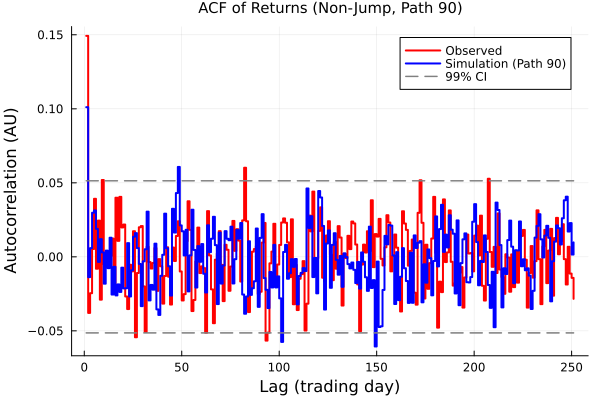

In [80]:
let
    random_index = rand(1:number_of_paths)
    simulated_path = in_sample_decoded_archive[:, random_index]
    plot_acf_comparison(Rᵢ, simulated_path, "ACF of Returns (Non-Jump, Path $(random_index))", random_index)
end

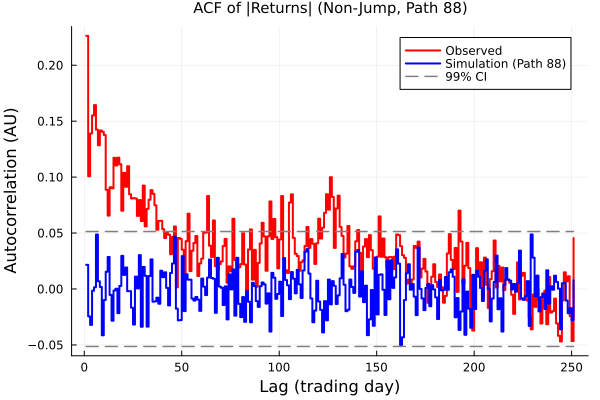

In [81]:
let
    random_index = rand(1:number_of_paths)
    simulated_path = in_sample_decoded_archive[:, random_index]
    plot_acf_comparison(Rᵢ, simulated_path, "ACF of |Returns| (Non-Jump, Path $(random_index))", random_index, is_absolute=true)
end

### Conclusion from the Non-Jump Model Analysis

The autocorrelation plots reveal a key insight:
* **Success:** The standard HMM successfully replicates the lack of significant autocorrelation in raw returns, consistent with the efficient market hypothesis.
* **Failure:** The model completely fails to reproduce the strong, persistent autocorrelation in **absolute returns**. This means the simple HMM **cannot capture volatility clustering**, a critical stylized fact of financial markets.

This failure motivates the need for a more sophisticated model, which we explore in `Simulation-Notebook-HMM-WithJumps`.

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team.

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. You should decide solely based on your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.